<a href="https://colab.research.google.com/github/kermityan/EPAM-DS-ML-Course-Notebooks/blob/main/Neural_Networks_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.experimental import enable_iterative_imputer
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, fbeta_score, mean_squared_error, roc_auc_score, roc_curve, r2_score

import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

try:
    from torchmetrics import Accuracy
    from torchmetrics import F1Score
except:
    !pip install torchmetrics
    from torchmetrics import Accuracy
    from torchmetrics import F1Score


import copy
from pathlib import Path
from timeit import default_timer as timer
# Import tqdm for progress bar
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 22.8 MB/s eta 0:00:00


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### Auxillary functions

In [ ]:
def rmse(y_gt, Y_pr):
  # Returns RMSE by given predicted values and ground truth
  return np.sqrt(mean_squared_error(y_gt, Y_pr))

In [ ]:
def report(y_data, predictions):
  # Prints classification report plus F2-score
  predictions = pd.DataFrame(predictions).copy()

  print(classification_report(y_data, predictions))
  print(f'F2-Score: {fbeta_score(y_data, predictions, beta=2.0):.2f}')

In [ ]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
def get_accuracy(y_true, y_prob):
    # Returns accuracy of the binary classification results
    assert y_true.ndim == 1 and y_true.size() == y_prob.size()
    y_prob = y_prob > 0.5
    return (y_true == y_prob).sum().item() / y_true.size(0)

In [ ]:
def plot_train_progress(train_losses, test_losses, train_acc, test_acc, epochs, metric_type="acc"):
    # Plots learning curves for the loss, and the metric (default - accuracy)

    epoch_count = [i for i in range(1,epochs+1)]
    train_loss = [x.item() for x in train_losses]
    test_loss = [x.item() for x in test_losses]

    if metric_type == "acc":
      m_name = 'Accuracy'
    elif metric_type == "r2":
      m_name = 'R2 Score'

    plt.subplots(1, 2, figsize=(24, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_count, train_loss, label="Train loss")
    plt.plot(epoch_count, test_loss, label="Test loss")
    plt.grid(linestyle=':', color='k')
    plt.title("Training and test loss curves")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend();

    plt.subplot(1, 2, 2)
    plt.plot(epoch_count, train_acc, label="Train " + m_name )
    plt.plot(epoch_count, test_acc, label="Test " + m_name)
    plt.grid(linestyle=':', color='k')
    plt.title("Training and test " + m_name + " curves")
    plt.ylabel(m_name)
    plt.xlabel("Epochs")
    plt.legend();
    plt.show()

In [ ]:
def model_save(model, name):
  # Saves models parameters

  # Create model save path
  MODEL_NAME = name
  MODEL_SAVE_PATH = FILE_PATH +'/'+ MODEL_NAME

  # Save the model state dict
  print(f"Saving model to: {MODEL_SAVE_PATH}")
  torch.save(obj=model.state_dict(),
            f=MODEL_SAVE_PATH)

In [ ]:
def load_model(model_cls, name):
  # Loads model's parameters

  loaded_model_1 = model_cls

  MODEL_SAVE_PATH = FILE_PATH +'/'+ name

  # Load model state dict
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

  # Put model to target device
  loaded_model_1.to(device)

  print(f"Loaded model:\n{loaded_model_1}")
  print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")
  return loaded_model_1

In [ ]:
SEED = 844

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
FILE_PATH = "/content/drive/MyDrive/ds_data/"

Mounted at /content/drive


## Linear Regression

First, we need to solve the regression task using a neural network. We should use the same dataset we worked with in the 'Linear Regression' module. So I've taken all following data preparation and EDA from my work under that module. Detailed comments could be find here: https://colab.research.google.com/drive/1XDFJX-n1ZJOOwSqTwGCLToFQnWqTRBAb?usp=sharing

In [ ]:
filename = 'AirQualityUCI.csv'
df = pd.read_csv(os.path.join(FILE_PATH, filename), sep=";")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


In [ ]:
TARGET = 'C6H6(GT)'

In [ ]:
df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True)

In [ ]:
df['Timestamp'] = df['Date'] + ' ' + df['Time']
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H.%M.%S')
df.drop(['Date','Time'], axis=1, inplace=True)

In [ ]:
obj_cols = list(df.select_dtypes(object))
for column in obj_cols:
  df[column]=df[column].str.replace(',','.')
  df[column] = df[column].astype(float)
df.dtypes

CO(GT)                  float64
PT08.S1(CO)             float64
NMHC(GT)                float64
C6H6(GT)                float64
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
Timestamp        datetime64[ns]
dtype: object

In [ ]:
df.isnull().sum()

CO(GT)           114
PT08.S1(CO)      114
NMHC(GT)         114
C6H6(GT)         114
PT08.S2(NMHC)    114
NOx(GT)          114
PT08.S3(NOx)     114
NO2(GT)          114
PT08.S4(NO2)     114
PT08.S5(O3)      114
T                114
RH               114
AH               114
Timestamp        114
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df = df.replace(-200, np.nan)

Put here Pandas Profiling with conclusions

In [ ]:
df = df.drop_duplicates(keep=False)

In [ ]:
df.drop(['NMHC(GT)'], axis=1, inplace=True)

In [ ]:
df = df.dropna(subset=['C6H6(GT)'])

In [ ]:
NUMERICAL = df.select_dtypes(include=['float64']).columns.tolist()
NUMERICAL

['CO(GT)',
 'PT08.S1(CO)',
 'C6H6(GT)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'RH',
 'AH']

In [ ]:
if TARGET in NUMERICAL:
    NUMERICAL.remove(TARGET)

In [ ]:
for col in NUMERICAL:
  df[col] = df[col].interpolate(method="linear")

In [ ]:
features = gen_features(
    columns=[[c] for c in NUMERICAL],
    classes=[
        {'class': StandardScaler}
    ]
)
mapper = DataFrameMapper(features)
len(features)

11

In [ ]:
df[TARGET].mean()

10.083105327549772

In [ ]:
target = df[TARGET].values
df.drop(['Timestamp'], axis=1, inplace=True)

In [ ]:
X = df.drop(TARGET, axis=1)
X = pd.DataFrame(mapper.fit_transform(X))
y = target

In [ ]:
X.shape

(8991, 11)

In [ ]:
X


0         1         2         3         4         5         6   \
0     0.346465  1.198550  0.400450 -0.362053  0.858660  0.094826  0.680947   
1    -0.076591  0.885284  0.059391 -0.679435  1.318156 -0.364327  0.296762   
2     0.064428  1.392038 -0.000575 -0.538377  1.185759  0.116690  0.285208   
3     0.064428  1.272260  0.033156 -0.331826  0.998845  0.291606  0.368977   
4    -0.358629  0.793147 -0.386608 -0.538377  1.438871  0.160419  0.097448   
...        ...       ...       ...       ...       ...       ...       ...   
8986  0.699012  0.986635  0.606584  1.179517 -1.154556  1.778386 -0.237630   
8987  0.205447  0.291000  0.329240  0.580018 -0.901444  1.537878 -0.555377   
8988  0.205447  0.194256  0.464164  0.277749 -0.905338  1.450420 -0.621815   
8989 -0.006082 -0.446096  0.081879 -0.014444 -0.519829  1.034996 -1.199537   
8990  0.064428 -0.132830  0.404198  0.136690 -0.706742  1.297369 -0.945339   

            7         8         9         10  
0     0.615100 -0.534197 -0.019300 -0.663043  
1    -0.127757 -0.568166 -0.088601 -0.743035  
2     0.128228 -0.726687  0.275226 -0.681865  
3     0.451972 -0.828594  0.621728 -0.591471  
4     0.218575 -0.805948  0.598628 -0.586271  
...        ...       ...       ...       ...  
8986  1.772048  0.405607 -1.151206 -0.665520  
8987  0.617609  0.677358 -1.474608 -0.776716  
8988  0.173401  0.971755 -1.786459 -0.953293  
8989 -0.634706  1.130276 -2.063661 -1.267070  
8990 -0.519262  1.152922 -2.086761 -1.294559  

[8991 rows x 11 columns]

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=SEED, shuffle=True, test_size=0.2)

At the output of data preparation we have got 11 scaled features and one dependent variable (target). I also splitted the whole dataset into train and test subsets.

## Baseline Model (one-layer, linear) - Regression

I am going to use Pytorch library during this work. First I am going to define a class of simple neural network containing just one layer with 11 incoming features, and 1 outgoing:

In [ ]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=11,
                                      out_features=1)

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x) # <- this is the linear regression formula (y = m*x + b)

Defining an object of the previously created class which will be our model's instance:

In [ ]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

Check the initial parameters (weights) of the model:

In [ ]:
model_0.state_dict()

OrderedDict([('linear_layer.weight',
              tensor([[ 0.2305,  0.2503, -0.0706,  0.2770, -0.0661,  0.0608, -0.1468,  0.1771,
                        0.2658, -0.2212,  0.2621]])),
             ('linear_layer.bias', tensor([0.0564]))])

Set model to GPU if it's availalble, otherwise it'll default to CPU:

In [ ]:
model_0.to(device)
next(model_0.parameters()).device

device(type='cpu')

Create the loss function, and the optimizer:

In [ ]:
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step)

Convert Pandas dataframes into Pytorch Tensors for further processing:

In [ ]:
X_train = torch.tensor(X_train.values.astype(np.float32))
X_test = torch.tensor(X_test.values.astype(np.float32))
y_train = torch.tensor(y_train.astype(np.float32))
y_test = torch.tensor(y_test.astype(np.float32))

Set the number of epochs (how many times the model will pass over the training data):

In [ ]:
epochs = 2200

Put data on the available device:

In [ ]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

Create empty loss lists to track values:

In [ ]:
train_loss_values = []
test_loss_values = []
epoch_count = []

Training loop:

In [ ]:
train_losses = []
test_losses = []
train_scores = []
test_scores = []
for epoch in range(epochs):
    ### Training

    # Put model in training mode
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)
    train_losses.append(loss)

    score = r2_score(y_train.detach().numpy(), y_pred.detach().numpy())
    train_scores.append(score)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test)
      test_losses.append(test_loss)
      test_score = r2_score(y_test.detach().numpy(), test_pred.detach().numpy())
      test_scores.append(test_score)

      # Print out what's happening
      if epoch % 100 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.cpu().detach().numpy())
            test_loss_values.append(test_loss.cpu().detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 10.017611503601074 | MAE Test Loss: 10.101739883422852 
Epoch: 100 | MAE Train Loss: 9.071393966674805 | MAE Test Loss: 9.158783912658691 
Epoch: 200 | MAE Train Loss: 8.228423118591309 | MAE Test Loss: 8.313708305358887 
Epoch: 300 | MAE Train Loss: 7.56130838394165 | MAE Test Loss: 7.6357293128967285 
Epoch: 400 | MAE Train Loss: 7.0734357833862305 | MAE Test Loss: 7.134225845336914 
Epoch: 500 | MAE Train Loss: 6.713334083557129 | MAE Test Loss: 6.765931606292725 
Epoch: 600 | MAE Train Loss: 6.444399833679199 | MAE Test Loss: 6.494242191314697 
Epoch: 700 | MAE Train Loss: 6.239750862121582 | MAE Test Loss: 6.286411285400391 
Epoch: 800 | MAE Train Loss: 6.084205627441406 | MAE Test Loss: 6.127843379974365 
Epoch: 900 | MAE Train Loss: 5.967761516571045 | MAE Test Loss: 6.0110764503479 
Epoch: 1000 | MAE Train Loss: 5.879034996032715 | MAE Test Loss: 5.9239583015441895 
Epoch: 1100 | MAE Train Loss: 5.809948921203613 | MAE Test Loss: 5.859047889709473 
Ep

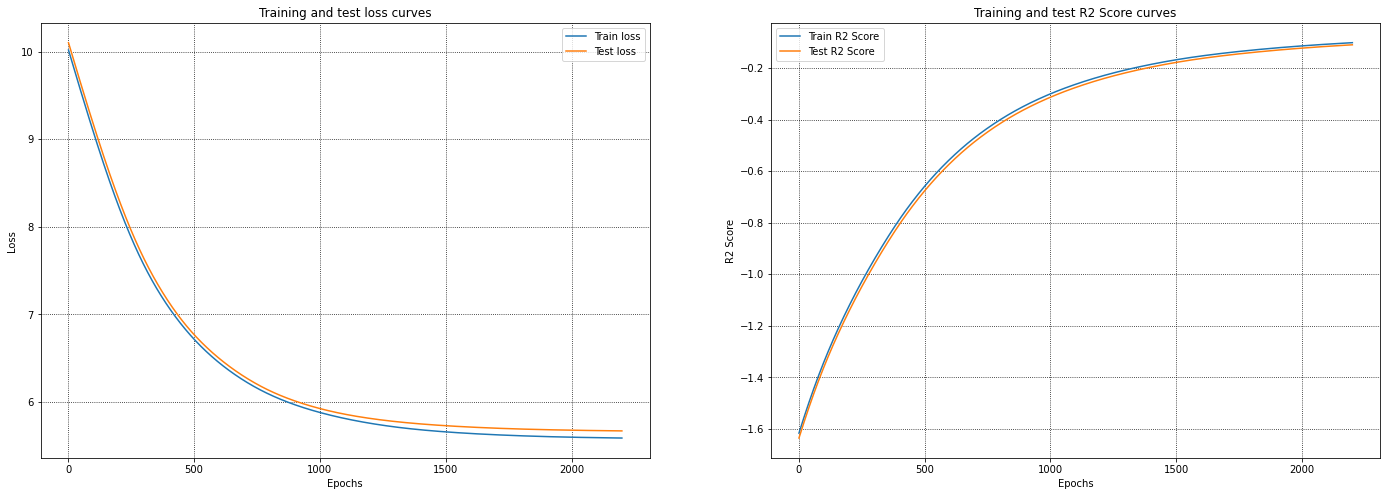

In [ ]:
plot_train_progress(train_losses, test_losses, train_scores, test_scores, 2200, metric_type="r2")

As we can see our very simple model works. It minimized loss and at the same time increased the R2 score for our regression task in only 2000 epochs. However R2 score seems not as good as we want to see - it is negative. That is because our model has only one layer which does a linear combination of the input parameters so if we have non-linear dependency between the target and inputs this one-layer model can't reflect it. So probably we need a more complex model to catch non-linearity and make predictions better.

Let's find out the model's learned parameters:

In [ ]:
from pprint import pprint
print("The model learned the following values for weights and bias:")
pprint(model_0.state_dict())

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight',
              tensor([[ 0.0406,  0.1398, -0.1151,  0.0123,  0.0312, -0.0438, -0.1274,  0.0715,
          0.0189, -0.0520,  0.0754]])),
             ('linear_layer.bias', tensor([8.1752]))])


Let's see how good are predictions that the simple model make:

In [ ]:
model_0.eval()
with torch.inference_mode():
    # Test out inference with 5 samples
    for i in range(5):
        X_sample = X_test[i: i+1]
        X_sample = torch.tensor(X_sample, dtype=torch.float32).to(device)
        y_pred = model_0(X_sample)
        print(f"{X_test[i]} -> {y_pred[0].cpu().numpy()} (expected {y_test[i].cpu().numpy()})")

tensor([-0.0061, -0.1236, -0.2967, -0.0396,  0.2356,  0.0292, -1.1504,  0.5398,
        -0.9871,  0.1424, -1.0135]) -> [8.280065] (expected 7.099999904632568)
tensor([-0.6407, -0.6764, -0.7352, -0.8003,  1.3610, -0.5174, -0.5900, -0.8355,
        -0.9758,  0.0673, -1.0382]) -> [8.109768] (expected 4.599999904632568)
tensor([-0.7817, -0.5014, -1.0725, -0.0497,  0.4225,  0.8164, -1.6502, -0.2307,
        -1.4061, -0.2388, -1.4969]) -> [8.240343] (expected 3.0)
tensor([-0.2881, -0.2111,  0.1718, -0.6542, -0.3913, -0.1020,  0.8254, -0.2081,
         1.7417, -0.9144,  1.7164]) -> [8.188347] (expected 10.199999809265137)
tensor([-0.5702, -1.1786, -0.8776, -0.3570,  0.7769, -0.3862, -1.3584, -0.8079,
        -0.7946, -0.4293, -1.1504]) -> [8.160941] (expected 3.9000000953674316)


Honestly, they are not good at all. We definetely need to train a better (non-linear) model.


In [ ]:
model_save("01_pytorch_linear_model_0.pth")

Saving model to: /content/drive/MyDrive/ds_data//01_pytorch_linear_model_0.pth


In [ ]:
linreg_model = load_model(LinearRegressionModel(),"01_pytorch_linear_model_0.pth")

Loaded model:
LinearRegressionModel(
  (linear_layer): Linear(in_features=11, out_features=1, bias=True)
)
Model on device:
cpu


In [ ]:
import gc
gc.collect()

0

In [ ]:
torch.cuda.empty_cache()

###Multilayer Model with ReLU - Regression

So as a next step I am going to create and train more complex multilayer model. Below is the class describing this model. It has four fully connected layers and ReLU activation functions between them. ReLU activations after linear layers give non-linearity to the model:

In [ ]:
# Define the model
model = nn.Sequential(
    nn.Linear(11, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

This time I choose MSE as a loss function and take a smaller learning rate:

In [ ]:
# loss function and optimizer
loss_fn_2 = nn.MSELoss()  # mean square error
optimizer_2 = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# train-test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

And another difference - this time I will use mini-batches the training process. This allow the algorythm to do a several loss-function optimization steps during one epoch.

In [ ]:
n_epochs = 30   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

In [ ]:
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

Training loop:

In [ ]:
train_losses = []
test_losses = []
train_scores = []
test_scores = []

for epoch in range(n_epochs):
    epoch_loss = epoch_score = num_batch =  0
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            num_batch += 1
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn_2(y_pred, y_batch)
            epoch_loss += loss/batch_size

            score = r2_score(y_batch.detach().numpy(), y_pred.detach().numpy())
            epoch_score += score

            # backward pass
            optimizer_2.zero_grad()
            loss.backward()
            # update weights
            optimizer_2.step()
            # print progress
            bar.set_postfix(mse=float(loss))

        train_losses.append(epoch_loss)
        train_scores.append(epoch_score/num_batch)
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn_2(y_pred, y_test)
    test_losses.append(mse)
    score = r2_score(y_test.detach().numpy(), y_pred.detach().numpy())
    test_scores.append(score)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)

<All keys matched successfully>

Let's see what loss and scores dynamics during training progress we got this time:

MSE: 0.36
RMSE: 0.60


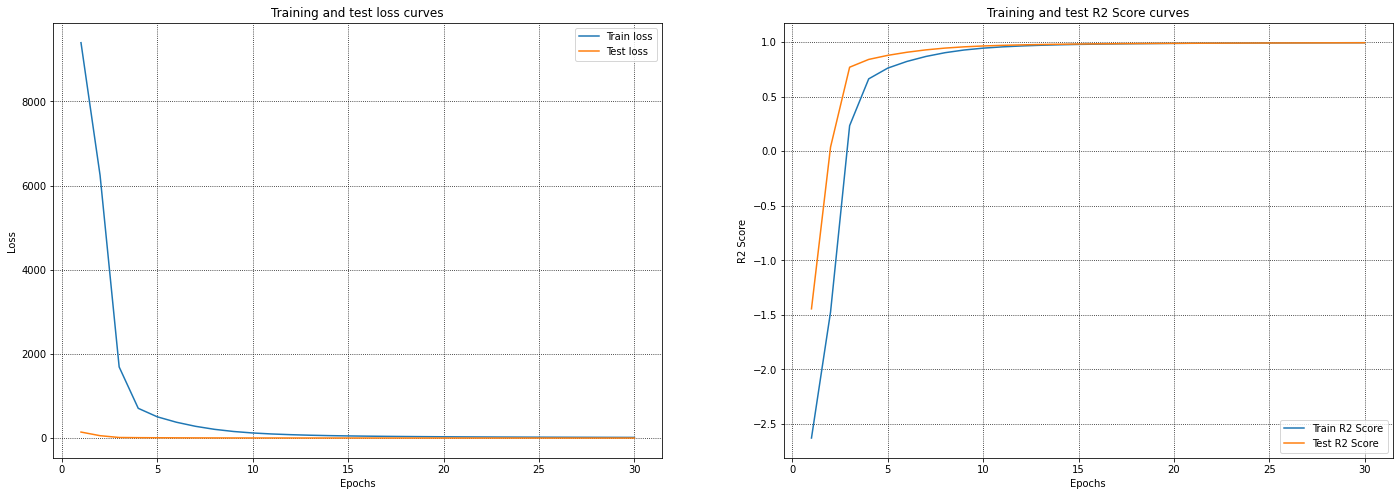

In [ ]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plot_train_progress(train_losses, test_losses, train_scores, test_scores, 30, metric_type="r2")

This looks much better. Seems that the new model works perfectly on this data. MSE and RMSE are near zero, and R2-score is very close to 1.

In [ ]:
model.eval()
with torch.inference_mode():
    # Test out inference with 5 samples
    for i in range(5):
        X_sample = X_test[i: i+1]
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        print(f"{X_test[i]} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

tensor([ 1.6861,  1.2999,  0.9626,  1.8495, -1.0222,  0.4009,  0.2505,  1.1170,
        -0.8965,  1.4649, -0.2133]) -> [16.481308] (expected [16.5])
tensor([ 1.2631,  0.9083,  0.6103,  1.4364, -1.2792,  1.7128, -0.2347,  1.4056,
        -0.0133, -0.7470, -0.6856]) -> [13.599525] (expected [13.6])
tensor([-0.4561, -0.3586, -0.0943, -0.5823,  1.1546,  0.0995, -0.0297, -0.4415,
         0.9151, -1.5093, -0.5949]) -> [8.30139] (expected [8.4])
tensor([ 1.9682,  2.3917,  1.7684,  1.4717, -1.6296,  1.4286,  1.3049,  1.6591,
         0.2358,  0.1540,  0.4967]) -> [24.079683] (expected [24.3])
tensor([-0.7112, -1.0680, -1.0950, -0.5384,  0.8509, -0.5174, -1.4277, -0.4891,
        -1.1230,  0.3041, -1.0484]) -> [2.8763654] (expected [2.9])


Predictions of the model are very close to real values.

In [ ]:
model_save(model, "02_pytorch_regression_relu_model.pth")

Saving model to: /content/drive/MyDrive/ds_data//02_pytorch_regression_relu_model.pth


## Classification

The next task I need to complete is to solve a simple classification problem using the neural networks approach. At this time I must use the Hypothyroid disease dataset which was already used in recent homework so now I'll take all the data preparation part from my previous work without a lot of commenting on these steps. For more comments on the data preparation and EDA please see here: https://colab.research.google.com/drive/1Z5IalkCVI3d8Bl3E06UUAtNsvvNp0M1a#scrollTo=5PgXOuWkH6XO  

#### Data preparation:

In [ ]:
file_name='dataset_57_hypothyroid.csv'
df = pd.read_csv(os.path.join(FILE_PATH, file_name))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3772 non-null   object
 1   sex                        3772 non-null   object
 2   on_thyroxine               3772 non-null   object
 3   query_on_thyroxine         3772 non-null   object
 4   on_antithyroid_medication  3772 non-null   object
 5   sick                       3772 non-null   object
 6   pregnant                   3772 non-null   object
 7   thyroid_surgery            3772 non-null   object
 8   I131_treatment             3772 non-null   object
 9   query_hypothyroid          3772 non-null   object
 10  query_hyperthyroid         3772 non-null   object
 11  lithium                    3772 non-null   object
 12  goitre                     3772 non-null   object
 13  tumor                      3772 non-null   object
 14  hypopitu

In [ ]:
TARGET = 'Class'

In [ ]:
df.drop(df[df['age']=='?'].index, inplace=True)
df.drop(df[df['age']=='455'].index, inplace=True)
df['age'] = df['age'].astype(int)
df.drop(['referral_source'], axis=1, inplace=True)

In [ ]:
bool_cols = list(df.select_dtypes(object))
categorical_cols = ['sex']
numeric_cols = ['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
bool_cols = [el for el in bool_cols if el not in categorical_cols and el not in numeric_cols and el != TARGET]
bool_cols
for column in bool_cols:
  df[column]=df[column].replace('f','0')
  df[column]=df[column].replace('t','1')
  df[column] = df[column].astype('int32')

In [ ]:
df = df.replace('?', np.nan)

In [ ]:
for column in numeric_cols:
  df[column] = df[column].astype(float)

In [ ]:
dropped_cols = set()
for column in bool_cols:
  if column.find('_measured') != -1:
    df.drop([column], axis=1, inplace=True)
    dropped_cols.add(column)
for i in dropped_cols:
  bool_cols.remove(i)

In [ ]:
df['Class'].value_counts()

negative                   3479
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

In [ ]:
df.loc[df[TARGET]=='compensated_hypothyroid', TARGET] = 1
df.loc[df[TARGET]=='primary_hypothyroid', TARGET] = 1
df.loc[df[TARGET]=='secondary_hypothyroid', TARGET] = 1
df.loc[df[TARGET]=='negative', TARGET] = 0

In [ ]:
df[TARGET] = df[TARGET].astype('int32')

In [ ]:
df.drop(['TBG'], axis=1, inplace=True)
numeric_cols.remove('TBG')

In [ ]:
iter_imputer = IterativeImputer(random_state=SEED)
scaler = StandardScaler()
iter_imputed = iter_imputer.fit_transform(df[numeric_cols])
num_scaled = scaler.fit_transform(iter_imputed)
df_num_imputed = pd.DataFrame(num_scaled, columns=numeric_cols)

In [ ]:
cat_imputer = SimpleImputer(strategy='constant', fill_value='M')
cat_encoder = OneHotEncoder(drop='first',sparse=False)
cat_imputed = cat_imputer.fit_transform(df[categorical_cols])
cat_encoded = cat_encoder.fit_transform(cat_imputed)
df_cat_imputed = pd.DataFrame(cat_encoded, columns=categorical_cols, dtype='int32')

In [ ]:
bool_imputer = SimpleImputer(strategy='constant', fill_value=0)
bool_imputed = bool_imputer.fit_transform(df[bool_cols])
df_bool_imputed = pd.DataFrame(bool_imputed, columns=bool_cols)

In [ ]:
X = pd.concat([df_cat_imputed, df_bool_imputed, df_num_imputed], axis = 1)
y = df[TARGET]

In [ ]:
X.shape

(3770, 20)

#### PCA for visualisation

There is no big necessity for this step but I wanted to visualize the dataset and check how target classes are distributed in the 2D space after PCA.

In [ ]:
pca = PCA(n_components=2)
new_X = pca.fit_transform(X)

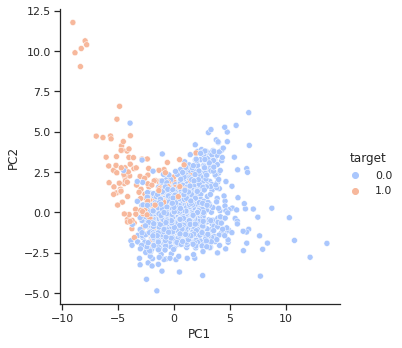

In [ ]:
plot_df = pd.DataFrame.from_records(data=new_X[:,:2],columns=["PC1","PC2"])
plot_df["target"] = y

sns.set(style="ticks")
sns.relplot(data=plot_df, x="PC1", y="PC2", hue="target", palette='coolwarm')

Preparing the data for training the models: converting to torch.tensors, and the train-test split:

In [ ]:
X = torch.tensor(X.values).type(torch.float)
y = torch.tensor(y.values).type(torch.float)

In [ ]:
X[:5], y[:5]

(tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.1606,
           0.6288,  0.4833,  0.7844, -0.0337],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0407,
          -0.0262, -0.1832, -0.0495, -0.1673],
         [ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.1743,
          -0.1053,  0.0197, -0.4547,  0.3114],
         [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.2094,
          -0.1572,  1.9322,  0.3356,  1.8430],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, shuffle=True, stratify=y, test_size=0.2)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(3016, 754, 3016, 754)

In [ ]:
device

'cpu'

#### Creating a NN model to use for classification

During data preparation, I combined all positive hypothyroid classes into one so here I am going to solve a binary classification problem where the target will be: 0 - no hypothyroid, 1 - hypothyroid.  

Let's create a class inherited from torch.nn.Module describing our neural network. It will contain a sequence of four fully connected layers with a ReLU activation function between them. The class also contains the 'forward' method which describes the sequence of data processing through the NN (forward pass):

In [ ]:
class ThyroidModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=20, out_features=40)
        self.layer_2 = nn.Linear(in_features=40, out_features=30)
        self.layer_3 = nn.Linear(in_features=30, out_features=10)
        self.layer_4 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))))) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
cls_model = ThyroidModelV0().to(device)
cls_model

ThyroidModelV0(
  (layer_1): Linear(in_features=20, out_features=40, bias=True)
  (layer_2): Linear(in_features=40, out_features=30, bias=True)
  (layer_3): Linear(in_features=30, out_features=10, bias=True)
  (layer_4): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

Let's try to make predictions with the untrained model:

In [ ]:
untrained_preds = cls_model(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 754, Shape: torch.Size([754, 1])
Length of test samples: 754, Shape: torch.Size([754])

First 10 predictions:
tensor([[-0.1932],
        [-0.1847],
        [-0.2017],
        [-0.2236],
        [-0.2102],
        [-0.2122],
        [-0.1957],
        [-0.2231],
        [-0.2123],
        [-0.2090]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Seems that it returns random numbers so to fix this we must train this model. To do this first I am defining the loss function and the optimizer. As we have a binary classification problem the best choice for the lost function is Binary Cross Entropy combined with the Sigmoid layer. For the optimizer, I will use Stochastic Gradient Descent.

In [ ]:
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

optimizer = torch.optim.SGD(params=cls_model.parameters(),
                            lr=0.1)

Auxillary function calculating the accuracy of the classification:

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

A few following cells explain how to get prediction labels from the NN output. First, the values we receive from the output layer of the NN are logits. In order to convert them into probabilities we must apply the sigmoid function to them. And then to get predicted labels we need to round these probabilities.

In [ ]:
y_logits = cls_model(X_test.to(device))[:5]
y_logits

tensor([[-0.1109],
        [-0.0732],
        [-0.0849],
        [-0.0505],
        [-0.1352]], grad_fn=<SliceBackward0>)

In [ ]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4723],
        [0.4817],
        [0.4788],
        [0.4874],
        [0.4663]], grad_fn=<SigmoidBackward0>)

In [ ]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(cls_model(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [ ]:
y_test[:5]

tensor([0., 0., 0., 0., 0.])

Building a training and testing loop:

In [ ]:
# Set the number of epochs
epochs = 4200

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

train_losses = []
test_losses = []
train_scores = []
test_scores = []

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    cls_model.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = cls_model(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    train_losses.append(loss)
    train_scores.append(acc)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    cls_model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = cls_model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        test_losses.append(test_loss)
        test_scores.append(test_acc)
    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.67149, Accuracy: 89.75% | Test loss: 0.65088, Test acc: 92.31%
Epoch: 100 | Loss: 0.26569, Accuracy: 92.27% | Test loss: 0.26431, Test acc: 92.31%
Epoch: 200 | Loss: 0.23791, Accuracy: 92.27% | Test loss: 0.23637, Test acc: 92.31%
Epoch: 300 | Loss: 0.19829, Accuracy: 92.27% | Test loss: 0.19683, Test acc: 92.31%
Epoch: 400 | Loss: 0.16817, Accuracy: 92.54% | Test loss: 0.16794, Test acc: 92.57%
Epoch: 500 | Loss: 0.13414, Accuracy: 94.40% | Test loss: 0.13337, Test acc: 94.56%
Epoch: 600 | Loss: 0.10720, Accuracy: 95.49% | Test loss: 0.10286, Test acc: 95.23%
Epoch: 700 | Loss: 0.09299, Accuracy: 96.09% | Test loss: 0.08729, Test acc: 95.89%
Epoch: 800 | Loss: 0.08593, Accuracy: 96.32% | Test loss: 0.08173, Test acc: 96.02%
Epoch: 900 | Loss: 0.08134, Accuracy: 96.42% | Test loss: 0.07878, Test acc: 96.42%
Epoch: 1000 | Loss: 0.07781, Accuracy: 96.35% | Test loss: 0.07676, Test acc: 96.42%
Epoch: 1100 | Loss: 0.07487, Accuracy: 96.55% | Test loss: 0.07515, Test acc:

Saving the model parameters:

In [ ]:
model_save(cls_model,"thyroid_classification_relu_model.pth")

Saving model to: /content/drive/MyDrive/ds_data//thyroid_classification_relu_model.pth


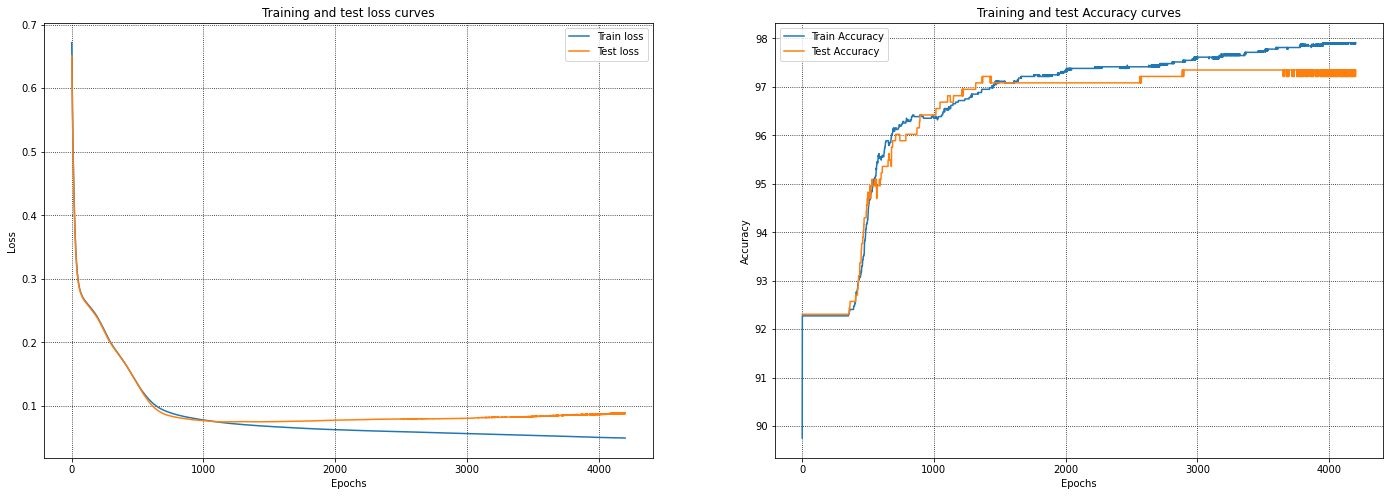

In [ ]:
plot_train_progress(train_losses, test_losses, train_scores, test_scores, 4200, metric_type="acc")

We can see that the model works. During the training process, we see that train and test accuracies increase to almost 98%.

In [ ]:
cls_model.eval()
with torch.inference_mode():
    # 1. Forward pass
    y_logits = cls_model(X_test).squeeze()
    y_pred_proba = torch.sigmoid(test_logits)
    y_pred = torch.round(y_pred_proba)

In [ ]:
report(y_test, y_pred)

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       696
         1.0       0.78      0.91      0.84        58

    accuracy                           0.97       754
   macro avg       0.89      0.95      0.91       754
weighted avg       0.98      0.97      0.97       754

F2-Score: 0.88


On the classification report, we see that we reached quite high numbers in precision and recall and also a relatively high F2-Score. These numbers are a bit lower than I got using Random Forest Classifier in the homework on classification (0.8 -precision and 0.93 - recall, for class 1).   

##Computer Vision: Detecting if there is a hotdog on the image

Auxiliary functions:

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

Explore directories with images:

In [ ]:
print(os.listdir(FILE_PATH + "/hotdog_data"))

In [ ]:
for (dirpath, dirnames, filenames) in os.walk(FILE_PATH + "/hotdog_data"):
    print("Directory path: ", dirpath)
    print("Folder name: ", dirnames)

Directory path:  /content/drive/MyDrive/ds_data//hotdog_data/train/0_not_hot_dog
Folder name:  []
Directory path:  /content/drive/MyDrive/ds_data//hotdog_data/train/1_hot_dog
Folder name:  []
Directory path:  /content/drive/MyDrive/ds_data//hotdog_data/test
Folder name:  ['0_not_hot_dog', '1_hot_dog']
Directory path:  /content/drive/MyDrive/ds_data//hotdog_data/test/0_not_hot_dog
Folder name:  []
Directory path:  /content/drive/MyDrive/ds_data//hotdog_data/test/1_hot_dog
Folder name:  []
Directory path:  /content/drive/MyDrive/ds_data//hotdog_data
Folder name:  ['train', 'test']
Directory path:  /content/drive/MyDrive/ds_data//hotdog_data/train
Folder name:  ['0_not_hot_dog', '1_hot_dog']
Directory path:  /content/drive/MyDrive/ds_data//hotdog_data/train/0_not_hot_dog
Folder name:  []
Directory path:  /content/drive/MyDrive/ds_data//hotdog_data/train/1_hot_dog
Folder name:  []
Directory path:  /content/drive/MyDrive/ds_data//hotdog_data/test
Folder name:  ['0_not_hot_dog', '1_hot_dog']

Defining dir names and counting images in every directory:

In [ ]:
base_dir = os.path.join(FILE_PATH, 'hotdog_data')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

train_hotdog_dir = os.path.join(train_dir, '1_hot_dog')  # directory with training hotdog pictures
train_not_hotdog_dir = os.path.join(train_dir, '0_not_hot_dog')  # directory with training not-hotdog pictures
test_hotdog_dir = os.path.join(test_dir, '1_hot_dog')  # directory with test hotdog pictures
test_not_hotdog_dir = os.path.join(test_dir, '0_not_hot_dog')  # directory with test not-hotdog pictures


num_nhd_tr = len(os.listdir(train_not_hotdog_dir))
num_hd_tr = len(os.listdir(train_hotdog_dir))


num_nhd_ts = len(os.listdir(test_not_hotdog_dir))
num_hd_ts = len(os.listdir(test_hotdog_dir))

total_train = num_hd_tr + num_nhd_tr
total_val = num_hd_ts + num_nhd_ts

print('total training hotdog images:', num_hd_tr)
print('total training not hotdog images:', num_nhd_tr)

print('total test hotdog:', num_hd_ts)
print('total test not hotdog:', num_nhd_ts)
print("---")
print("Total training images:", total_train)
print("Total test images:", total_val)

total training hotdog images: 249
total training not hotdog images: 249
total test hotdog: 260
total test not hotdog: 250
---
Total training images: 498
Total test images: 510
total training hotdog images: 249
total training not hotdog images: 249
total test hotdog: 260
total test not hotdog: 250
---
Total training images: 498
Total test images: 510


###Data Augmentation

A common strategy for training neural networks is to introduce randomness in the input data itself. For example, we can randomly rotate, mirror, scale, and/or crop images during training. This will help neural network generalize as it's seeing the same images but in different locations, with different sizes, in different orientations, etc. To provide this ability I will use data augmentation technique based on Pytorch transforms.

Defining parameters for images transformation: final size of images, mean and standard deviation for normalization:

In [ ]:
IMG_SIZE = 112  # Size of images used for training
IMG_MEAN = [0.5, 0.5, 0.5]
IMG_SDEV = [0.225, 0.225, 0.225]

We are groupping different transformations in two separate Compose classes - for training and for testing sets. Following transform operations are applied to original images at every batch generation. So the variety of the images during the training will increase significantly by random Crop, Rotation, and HorisontalFlip transformations.

In [ ]:
train_transform = transforms.Compose([transforms.Resize(128),
                                      transforms.RandomResizedCrop(IMG_SIZE),
                                      transforms.ColorJitter(hue=.05, saturation=.05),
                                      transforms.RandomRotation(30),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor(),
                                      transforms.Normalize(IMG_MEAN, IMG_SDEV),

                                      ])
test_transform = transforms.Compose([transforms.Resize(128),
                                     transforms.CenterCrop(IMG_SIZE),
                                     transforms.ToTensor(),
                                     #transforms.Normalize(IMG_MEAN, IMG_SDEV),
                                    ])

Defining the batch size:

In [ ]:
BATCH_SIZE = 32

At this stage, we should define ImageFolder-s objects which take images from the actual directories on the disc, transform them using previously defined Compose classes, and also assign labels depending on the folder where the image was taken. Then we'll define DataLoaders - objects which actually perform mini-batching - give the model random batches from the linked ImageFolder. DataLoaders will be used in further training and testing.

In [ ]:
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE)

print(f"Dataloaders: {trainloader, testloader}")
print(f"Length of train dataloader: {len(trainloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(testloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f59143a5520>, <torch.utils.data.dataloader.DataLoader object at 0x7f59143a55b0>)
Length of train dataloader: 16 batches of 32
Length of test dataloader: 16 batches of 32


Let's check how our DataLoader works and also how transformed images look like:

tensor(1)
tensor(0)
tensor(1)
tensor(0)


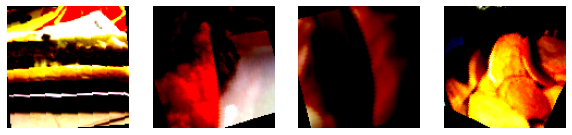

In [ ]:
data_iter = iter(trainloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=False)
    print(labels[ii])

It is also necessary to check the batch and labels tensors sizes before starting to build models:

In [ ]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(trainloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 112, 112]), torch.Size([32]))

We have batches of 16 images each, and every image has 3 color channels and 224x224 resolution. Consequently, we have got 16 labels per batch.


### Baseline model

Defining a few functions which I will use later in training process of the different models:

In [ ]:
def train_step(model, x, y):
    # The core of the NN training loop
    #make prediction
    yhat = model(x)
    #enter train mode
    model.train()
    #compute loss

    #print(yhat.squeeze(1))
    #probs = torch.sigmoid(yhat)
    y_pred = (yhat > 0.5).float()

    #print(probs.squeeze(1))
    print(y_pred.squeeze(1))
    print(y.squeeze(1))

    loss = loss_fn(y_pred,y)
    print(loss)
    loss.requires_grad = True

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss, yhat

In [ ]:
def model_train(trainloader: torch.utils.data.DataLoader,
                testloader: torch.utils.data.DataLoader,
                model: torch.nn.Module,
                loss_fn: torch.nn.Module,
                device: torch.device = device,
                n_epochs = 50):

  # Training the model: perform a training-testing loop for a given model over a given number of epochs
  # On each epoch, it's calculating and saving the loss and the accuracy, and after finishing returns respective lists to the main program

  losses = []
  val_losses = []

  epoch_train_losses = []
  epoch_test_losses = []
  epoch_train_accuracy = []
  epoch_test_accuracy = []

  early_stopping_tolerance = 3
  early_stopping_threshold = 0.03

  for epoch in range(n_epochs):
    epoch_loss = train_acc = 0
    #enter train mode
    model.train()

    for i, data in tqdm(enumerate(trainloader), total = len(trainloader)): #iterate over batches
      x_batch , y_batch = data
      x_batch = x_batch.to(device) #move to gpu
      y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
      y_batch = y_batch.to(device)

      #loss, yhat = train_step(model, x_batch, y_batch)

      optimizer.zero_grad()

      yhat = model(x_batch)
      probs = torch.sigmoid(yhat)
      y_pred = (yhat > 0.5).float()

      #print(yhat.squeeze(1))
      #print(y_pred.squeeze(1))
      #print(y_batch.squeeze(1))


      #compute loss
      loss = loss_fn(yhat,y_batch)
      #print(loss)
      #loss.requires_grad = True

      loss.backward()
      optimizer.step()
  #   optimizer.zero_grad()

      #print(get_accuracy(y_batch.squeeze(1), y_pred.squeeze(1))  )

      epoch_loss += loss/len(trainloader)

      train_acc += get_accuracy(y_batch.squeeze(1), y_pred.squeeze(1))
      losses.append(loss)
    train_acc /= len(trainloader)
    epoch_train_accuracy.append(train_acc)
    epoch_train_losses.append(epoch_loss)
    print('\nEpoch : {}, train loss : {}, train accuracy: {}'.format(epoch+1,epoch_loss,train_acc))


    with torch.inference_mode():    # Turn on inference context manager
      cum_loss = test_acc = 0
      #model to eval mode
      model.eval()

      for x_batch, y_batch in testloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.unsqueeze(1).float()
        y_batch = y_batch.to(device)

        yhat = model(x_batch)
        probs = torch.sigmoid(yhat)
        y_pred = (yhat > 0.5).float()

        val_loss = loss_fn(yhat, y_batch)
        cum_loss += val_loss/len(testloader)
        val_losses.append(val_loss.item())
        acc = get_accuracy(y_batch.squeeze(1), y_pred.squeeze(1))

        #print(yhat.squeeze(1))
        #print(y_pred.squeeze(1))
        #print(y_batch.squeeze(1))
        #print(acc)

        test_acc += get_accuracy(y_batch.squeeze(1), y_pred.squeeze(1))   #y_batch.squeeze(1)

      test_acc /= len(testloader)
      epoch_test_accuracy.append(test_acc)
      epoch_test_losses.append(cum_loss)
      print('Epoch : {}, val loss : {}, test accuracy : {}'.format(epoch+1, cum_loss, test_acc))

      best_loss = min(epoch_test_losses)

      #save best model
      if cum_loss <= best_loss:
        best_model_wts = model.state_dict()

      #early stopping
      early_stopping_counter = 0
      if cum_loss > best_loss:
        early_stopping_counter +=1

      if (early_stopping_counter == early_stopping_tolerance) or (best_loss <= early_stopping_threshold):
        print("/nTerminating: early stopping")
        break #terminate training

  #load best model
  model.load_state_dict(best_model_wts)

  return model, epoch_train_losses, epoch_test_losses, epoch_train_accuracy, epoch_test_accuracy

In [ ]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device = device):
    """Evaluates a given model on a given dataset.
       Returns: (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:

            #print(y)

            # Send data to the target device
            X, y = X.to(device), y.to(device)
            logits = model(X).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
            y_pred = torch.round(torch.sigmoid(logits)) # turn logits -> pred probs -> pred labls
            #print(y_pred)
            loss += loss_fn(logits, y.float())
            acc += get_accuracy(y.float(), y_pred)

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}


In [ ]:
def inference(model, test_data):
  # Makes a single prediction using the given model

  idx = torch.randint(1, len(test_data), (1,))
  sample = torch.unsqueeze(test_data[idx][0], dim=0).to(device)

  if torch.sigmoid(model(sample)) < 0.5:
    print("Prediction : Not a hotdog")
  else:
    print("Prediction : Hotdog")


  plt.imshow(test_data[idx][0].permute(1, 2, 0))


Let's build a simple convolutional neural network and try to train it. In the cell below there is the class that describes the NN structure and forward pass behavior. It has two structure blocks - the first composed of convolution layers alternating with ReLU activators and MaxPool layers, the second is a classifier which contained of several fully connected layers (again with ReLU activators in between).

In [ ]:
class SimpleHotdogCNNModel(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            # 64x64   112
            nn.Conv2d(in_channels=input_shape,
                      out_channels=32,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                      stride=2),
            # 32x32    56
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2),
            #16x16      28
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2),
            #8x8        14
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2),
            #4x4            7

        )
            #4x4
        self.classifier = nn.Sequential(
            nn.Flatten(),
            #
            nn.Linear(in_features=128*7*7,
                      out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024,
                      out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,
                      out_features=output_shape),
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.classifier(x)
        return x


model_1 = SimpleHotdogCNNModel(input_shape=3,
    output_shape=1).to(device)
model_1

SimpleHotdogCNNModel(
  (block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in

Let's check how will change the dimensionality of the tensor being passed through the NN, and also how many parameters the NN should learn on each layer and in total:

In [ ]:
from torchsummary import summary
summary(model_1, input_size=(3, 112, 112),device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
              ReLU-2         [-1, 32, 112, 112]               0
         MaxPool2d-3           [-1, 32, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]          18,496
              ReLU-5           [-1, 64, 56, 56]               0
         MaxPool2d-6           [-1, 64, 28, 28]               0
            Conv2d-7           [-1, 64, 28, 28]          36,928
              ReLU-8           [-1, 64, 28, 28]               0
         MaxPool2d-9           [-1, 64, 14, 14]               0
           Conv2d-10          [-1, 128, 14, 14]          73,856
             ReLU-11          [-1, 128, 14, 14]               0
        MaxPool2d-12            [-1, 128, 7, 7]               0
          Flatten-13                 [-1, 6272]               0
           Linear-14                 [-

Defining the loss function and the optimizer:

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()   #WithLogits
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

Training the model:

In [ ]:
model_1, m1_train_loss, m1_test_losses, m1_train_acc, m1_test_acc = model_train(trainloader, testloader, model_1, loss_fn, device, 100)

  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 1, train loss : 0.6909348964691162, train accuracy: 0.5
Epoch : 1, val loss : 0.6931348443031311, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 2, train loss : 0.6778039932250977, train accuracy: 0.4969618055555556
Epoch : 2, val loss : 0.6953683495521545, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 3, train loss : 0.6810562610626221, train accuracy: 0.517578125
Epoch : 3, val loss : 0.6925832629203796, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 4, train loss : 0.6839750409126282, train accuracy: 0.5
Epoch : 4, val loss : 0.6947836875915527, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 5, train loss : 0.6769715547561646, train accuracy: 0.4891493055555556
Epoch : 5, val loss : 0.7108234167098999, test accuracy : 0.621875


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 6, train loss : 0.6648972630500793, train accuracy: 0.5054253472222222
Epoch : 6, val loss : 0.7094116806983948, test accuracy : 0.58125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 7, train loss : 0.6622331142425537, train accuracy: 0.5238715277777778
Epoch : 7, val loss : 0.6986849308013916, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 8, train loss : 0.6680360436439514, train accuracy: 0.5023871527777778
Epoch : 8, val loss : 0.7137507796287537, test accuracy : 0.4984375


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 9, train loss : 0.6519384980201721, train accuracy: 0.55859375
Epoch : 9, val loss : 0.7341051697731018, test accuracy : 0.51171875


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 10, train loss : 0.672691285610199, train accuracy: 0.5234375
Epoch : 10, val loss : 0.7224708795547485, test accuracy : 0.5272135416666667


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 11, train loss : 0.6568142175674438, train accuracy: 0.5592447916666666
Epoch : 11, val loss : 0.7164947390556335, test accuracy : 0.505078125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 12, train loss : 0.6700413227081299, train accuracy: 0.5182291666666666
Epoch : 12, val loss : 0.696742594242096, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 13, train loss : 0.6697072982788086, train accuracy: 0.5151909722222222
Epoch : 13, val loss : 0.722913920879364, test accuracy : 0.5044270833333333


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 14, train loss : 0.6502643823623657, train accuracy: 0.5592447916666666
Epoch : 14, val loss : 0.8437047004699707, test accuracy : 0.51171875


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 15, train loss : 0.6395377516746521, train accuracy: 0.6334635416666666
Epoch : 15, val loss : 0.7181809544563293, test accuracy : 0.5059895833333333


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 16, train loss : 0.6533225178718567, train accuracy: 0.5062934027777778
Epoch : 16, val loss : 0.7025794386863708, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 17, train loss : 0.6391660571098328, train accuracy: 0.5687934027777778
Epoch : 17, val loss : 0.7057698369026184, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 18, train loss : 0.6329123377799988, train accuracy: 0.5549045138888888
Epoch : 18, val loss : 0.7269949913024902, test accuracy : 0.5115885416666667


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 19, train loss : 0.6475982666015625, train accuracy: 0.6037326388888888
Epoch : 19, val loss : 0.7067670822143555, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 20, train loss : 0.6478928923606873, train accuracy: 0.5123697916666666
Epoch : 20, val loss : 0.6990849375724792, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 21, train loss : 0.6473641991615295, train accuracy: 0.5948350694444444
Epoch : 21, val loss : 0.7068514227867126, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 22, train loss : 0.632657527923584, train accuracy: 0.5831163194444444
Epoch : 22, val loss : 0.726982057094574, test accuracy : 0.485546875


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 23, train loss : 0.6164515018463135, train accuracy: 0.6538628472222222
Epoch : 23, val loss : 0.7627672553062439, test accuracy : 0.51171875


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 24, train loss : 0.6318010687828064, train accuracy: 0.6139322916666666
Epoch : 24, val loss : 0.7255138754844666, test accuracy : 0.4515625


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 25, train loss : 0.6215881109237671, train accuracy: 0.6384548611111112
Epoch : 25, val loss : 0.7409628629684448, test accuracy : 0.51171875


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 26, train loss : 0.6528268456459045, train accuracy: 0.5944010416666666
Epoch : 26, val loss : 0.6972829103469849, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 27, train loss : 0.6339781880378723, train accuracy: 0.5078125
Epoch : 27, val loss : 0.702849268913269, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 28, train loss : 0.6199225783348083, train accuracy: 0.6310763888888888
Epoch : 28, val loss : 0.7266805768013, test accuracy : 0.44700520833333335


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 29, train loss : 0.6186124682426453, train accuracy: 0.6260850694444444
Epoch : 29, val loss : 0.711846649646759, test accuracy : 0.4766927083333333


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 30, train loss : 0.6361128091812134, train accuracy: 0.6204427083333334
Epoch : 30, val loss : 0.7044208645820618, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 31, train loss : 0.6376125812530518, train accuracy: 0.6391059027777778
Epoch : 31, val loss : 0.7218355536460876, test accuracy : 0.44479166666666664


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 32, train loss : 0.6282787919044495, train accuracy: 0.609375
Epoch : 32, val loss : 0.7025104761123657, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 33, train loss : 0.6120376586914062, train accuracy: 0.6378038194444444
Epoch : 33, val loss : 0.7190433144569397, test accuracy : 0.4440104166666667


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 34, train loss : 0.6297491192817688, train accuracy: 0.6041666666666666
Epoch : 34, val loss : 0.7196809649467468, test accuracy : 0.4342447916666667


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 35, train loss : 0.6515204906463623, train accuracy: 0.5726996527777778
Epoch : 35, val loss : 0.7038148641586304, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 36, train loss : 0.6296629309654236, train accuracy: 0.6059027777777778
Epoch : 36, val loss : 0.721542239189148, test accuracy : 0.442578125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 37, train loss : 0.6234095096588135, train accuracy: 0.6475694444444444
Epoch : 37, val loss : 0.7026470303535461, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 38, train loss : 0.6129564046859741, train accuracy: 0.6393229166666666
Epoch : 38, val loss : 0.7032428979873657, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 39, train loss : 0.6025983691215515, train accuracy: 0.6358506944444444
Epoch : 39, val loss : 0.7028303742408752, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 40, train loss : 0.6099331974983215, train accuracy: 0.6553819444444444
Epoch : 40, val loss : 0.7098504900932312, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 41, train loss : 0.6215723752975464, train accuracy: 0.5870225694444444
Epoch : 41, val loss : 0.7083660364151001, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 42, train loss : 0.6172584295272827, train accuracy: 0.6467013888888888
Epoch : 42, val loss : 0.7207852602005005, test accuracy : 0.48098958333333336


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 43, train loss : 0.5889126658439636, train accuracy: 0.6901041666666666
Epoch : 43, val loss : 0.7296237945556641, test accuracy : 0.5110677083333334


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 44, train loss : 0.6378792524337769, train accuracy: 0.6148003472222222
Epoch : 44, val loss : 0.6944164633750916, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 45, train loss : 0.6186174750328064, train accuracy: 0.6623263888888888
Epoch : 45, val loss : 0.688853919506073, test accuracy : 0.490234375


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 46, train loss : 0.636005699634552, train accuracy: 0.6538628472222222
Epoch : 46, val loss : 0.6968421936035156, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 47, train loss : 0.629030168056488, train accuracy: 0.59375
Epoch : 47, val loss : 0.7233806252479553, test accuracy : 0.44921875


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 48, train loss : 0.6025716066360474, train accuracy: 0.6623263888888888
Epoch : 48, val loss : 0.7067763805389404, test accuracy : 0.486328125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 49, train loss : 0.612387478351593, train accuracy: 0.630859375
Epoch : 49, val loss : 0.7098594903945923, test accuracy : 0.490234375


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 50, train loss : 0.6056856513023376, train accuracy: 0.6746961805555556
Epoch : 50, val loss : 0.7135932445526123, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 51, train loss : 0.5780332088470459, train accuracy: 0.6979166666666666
Epoch : 51, val loss : 0.7226203083992004, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 52, train loss : 0.5797615647315979, train accuracy: 0.6853298611111112
Epoch : 52, val loss : 0.7336642146110535, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 53, train loss : 0.6167251467704773, train accuracy: 0.6569010416666666
Epoch : 53, val loss : 0.7055843472480774, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 54, train loss : 0.6098154187202454, train accuracy: 0.6510416666666666
Epoch : 54, val loss : 0.7059796452522278, test accuracy : 0.494140625


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 55, train loss : 0.6042397618293762, train accuracy: 0.6417100694444444
Epoch : 55, val loss : 0.70238196849823, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 56, train loss : 0.5756189227104187, train accuracy: 0.6482204861111112
Epoch : 56, val loss : 0.7083331942558289, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 57, train loss : 0.6065924763679504, train accuracy: 0.6551649305555556
Epoch : 57, val loss : 0.7108873128890991, test accuracy : 0.490234375


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 58, train loss : 0.56426602602005, train accuracy: 0.6857638888888888
Epoch : 58, val loss : 0.7100933194160461, test accuracy : 0.490234375


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 59, train loss : 0.5878818035125732, train accuracy: 0.6744791666666666
Epoch : 59, val loss : 0.7059882283210754, test accuracy : 0.4921875


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 60, train loss : 0.5651181936264038, train accuracy: 0.6963975694444444
Epoch : 60, val loss : 0.7126256823539734, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 61, train loss : 0.581192135810852, train accuracy: 0.677734375
Epoch : 61, val loss : 0.7240846753120422, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 62, train loss : 0.5791460275650024, train accuracy: 0.6740451388888888
Epoch : 62, val loss : 0.7291566133499146, test accuracy : 0.4783854166666667


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 63, train loss : 0.5679174661636353, train accuracy: 0.689453125
Epoch : 63, val loss : 0.7119295597076416, test accuracy : 0.484765625


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 64, train loss : 0.5670238733291626, train accuracy: 0.6838107638888888
Epoch : 64, val loss : 0.69443279504776, test accuracy : 0.4921875


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 65, train loss : 0.5631840825080872, train accuracy: 0.6701388888888888
Epoch : 65, val loss : 0.6975035667419434, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 66, train loss : 0.5764517188072205, train accuracy: 0.6861979166666666
Epoch : 66, val loss : 0.702926516532898, test accuracy : 0.490234375


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 67, train loss : 0.6199735403060913, train accuracy: 0.6217447916666666
Epoch : 67, val loss : 0.6969211101531982, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 68, train loss : 0.5722228288650513, train accuracy: 0.6890190972222222
Epoch : 68, val loss : 0.7006241679191589, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 69, train loss : 0.586775004863739, train accuracy: 0.6527777777777778
Epoch : 69, val loss : 0.7020745277404785, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 70, train loss : 0.5823783874511719, train accuracy: 0.662109375
Epoch : 70, val loss : 0.7033064961433411, test accuracy : 0.537890625


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 71, train loss : 0.5620262622833252, train accuracy: 0.6799045138888888
Epoch : 71, val loss : 0.6958159804344177, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 72, train loss : 0.5404826998710632, train accuracy: 0.6872829861111112
Epoch : 72, val loss : 0.7342438697814941, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 73, train loss : 0.5791898369789124, train accuracy: 0.6890190972222222
Epoch : 73, val loss : 0.7349162697792053, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 74, train loss : 0.5801746845245361, train accuracy: 0.6846788194444444
Epoch : 74, val loss : 0.717240571975708, test accuracy : 0.46536458333333336


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 75, train loss : 0.594902753829956, train accuracy: 0.6510416666666666
Epoch : 75, val loss : 0.69353187084198, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 76, train loss : 0.5445170402526855, train accuracy: 0.7003038194444444
Epoch : 76, val loss : 0.6984229683876038, test accuracy : 0.490234375


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 77, train loss : 0.5596728920936584, train accuracy: 0.681640625
Epoch : 77, val loss : 0.7091267108917236, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 78, train loss : 0.5382580161094666, train accuracy: 0.6697048611111112
Epoch : 78, val loss : 0.6949706673622131, test accuracy : 0.490234375


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 79, train loss : 0.5654218196868896, train accuracy: 0.6851128472222222
Epoch : 79, val loss : 0.696901261806488, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 80, train loss : 0.5692039132118225, train accuracy: 0.6809895833333334
Epoch : 80, val loss : 0.6921532154083252, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 81, train loss : 0.5047338008880615, train accuracy: 0.7330729166666666
Epoch : 81, val loss : 0.7617793083190918, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 82, train loss : 0.5486367344856262, train accuracy: 0.6768663194444444
Epoch : 82, val loss : 0.7116965651512146, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 83, train loss : 0.540336549282074, train accuracy: 0.7178819444444444
Epoch : 83, val loss : 0.7125701308250427, test accuracy : 0.5651041666666666


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 84, train loss : 0.5152772665023804, train accuracy: 0.7365451388888888
Epoch : 84, val loss : 0.7143155336380005, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 85, train loss : 0.5624902844429016, train accuracy: 0.6731770833333334
Epoch : 85, val loss : 0.692151665687561, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 86, train loss : 0.5530503392219543, train accuracy: 0.7189670138888888
Epoch : 86, val loss : 0.695529580116272, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 87, train loss : 0.5907713770866394, train accuracy: 0.6549479166666666
Epoch : 87, val loss : 0.7018523216247559, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 88, train loss : 0.5378726720809937, train accuracy: 0.7100694444444444
Epoch : 88, val loss : 0.7033655643463135, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 89, train loss : 0.5146462917327881, train accuracy: 0.7252604166666666
Epoch : 89, val loss : 0.7026879787445068, test accuracy : 0.490234375


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 90, train loss : 0.5182100534439087, train accuracy: 0.7291666666666666
Epoch : 90, val loss : 0.7058177590370178, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 91, train loss : 0.5277277231216431, train accuracy: 0.7107204861111112
Epoch : 91, val loss : 0.7046769261360168, test accuracy : 0.490234375


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 92, train loss : 0.48826029896736145, train accuracy: 0.7322048611111112
Epoch : 92, val loss : 0.6944872140884399, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 93, train loss : 0.5130347013473511, train accuracy: 0.7350260416666666
Epoch : 93, val loss : 0.7086594700813293, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 94, train loss : 0.5238710641860962, train accuracy: 0.7065972222222222
Epoch : 94, val loss : 0.7171797156333923, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 95, train loss : 0.5353937745094299, train accuracy: 0.7567274305555556
Epoch : 95, val loss : 0.6960043907165527, test accuracy : 0.486328125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 96, train loss : 0.5190603733062744, train accuracy: 0.7326388888888888
Epoch : 96, val loss : 0.6987572312355042, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 97, train loss : 0.5061644315719604, train accuracy: 0.7415364583333334
Epoch : 97, val loss : 0.7141661047935486, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 98, train loss : 0.4926368296146393, train accuracy: 0.7443576388888888
Epoch : 98, val loss : 0.7187488675117493, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 99, train loss : 0.4536406099796295, train accuracy: 0.7638888888888888
Epoch : 99, val loss : 0.7274450659751892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 100, train loss : 0.4981331527233124, train accuracy: 0.7428385416666666
Epoch : 100, val loss : 0.7243510484695435, test accuracy : 0.48828125


Evaluating the model:

In [ ]:
model_1_results = eval_model(model=model_1, data_loader=testloader,
    loss_fn=loss_fn
)
model_1_results

{'model_name': 'SimpleHotdogCNNModel',
 'model_loss': 0.6913904547691345,
 'model_acc': 0.494140625}

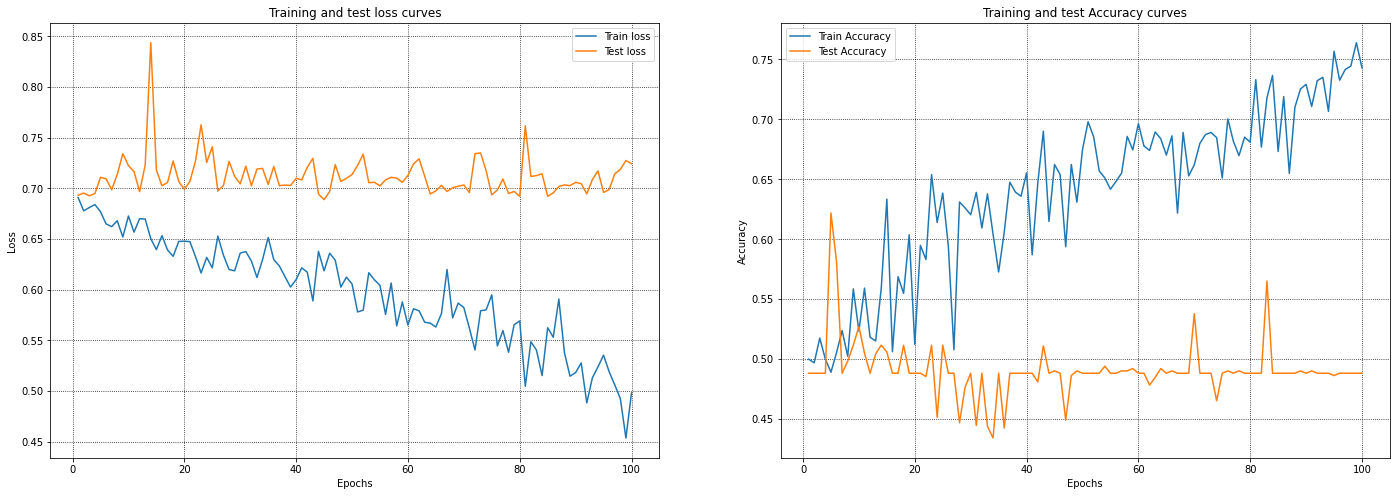

In [ ]:
plot_train_progress(m1_train_loss, m1_test_losses, m1_train_acc, m1_test_acc, 100)

In [ ]:
model_11_results = eval_model(model=model_1, data_loader=testloader,
    loss_fn=loss_fn
)
model_11_results

Prediction : Not a hotdog


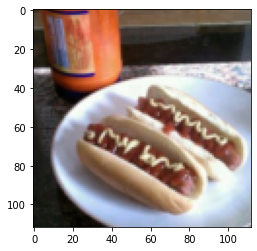

In [ ]:
inference(model_1, test_data)

As we can see the simple CNN model couldn't show any decent results after some training. The model learned train set and increase the accuracy of prediction train data, but it doesn't predict test data at all. All predictions on test set are zeros. There might be several reasons for it: 1) error in the model structure or in the train loop, 2) not sufficient complexity of the model (insufficiency of convolutional layers or some other structures)

Let's try to use some of the pretrained models which are available in torch.models library and compare their results.

### Pretrained Resnet18 model

First, I'll try Resnet18 model. For pre-trained models, I need to change the last layer of the fully-connected block because as we have a binary classification task, NN for this task should have one output giving zeroes or ones as a predicted class label, but all the pre-trained models have 1000 outputs or so.

In [ ]:
model_X = models.resnet18(pretrained=True)

#freeze all params
for params in model_X.parameters():
  params.requires_grad_ = False
#add a new final layer
nr_filters = model_X.fc.in_features  #number of input features of last layer
model_X.fc = nn.Linear(nr_filters, 1)

model_X = model_X.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Defining the loss function (Binary Cross Entropy with built-in sigmoid function), and optimizer (Adam):

In [ ]:
#loss
loss_fn = nn.BCEWithLogitsLoss() #binary cross entropy with sigmoid, so no need to use sigmoid in the model

#optimizer
optimizer = torch.optim.Adam(model_X.fc.parameters())

Let's see what we get if we train Resnet model on our dataset:

In [ ]:
model_X, resn_train_loss, resn_test_loss,resn_train_acc, resn_test_acc  = model_train(trainloader, testloader, model_X, loss_fn, device, 30)

  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 1, train loss : 0.6976967453956604, train accuracy: 0.486328125
Epoch : 1, val loss : 0.6742191314697266, test accuracy : 0.5750558035714286


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 2, train loss : 0.6280830502510071, train accuracy: 0.587890625
Epoch : 2, val loss : 0.6108060479164124, test accuracy : 0.6473214285714286


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 3, train loss : 0.592392086982727, train accuracy: 0.658203125
Epoch : 3, val loss : 0.5813332796096802, test accuracy : 0.6316964285714286


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 4, train loss : 0.5699183940887451, train accuracy: 0.658203125
Epoch : 4, val loss : 0.5503492951393127, test accuracy : 0.6258370535714286


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 5, train loss : 0.5407806634902954, train accuracy: 0.693359375
Epoch : 5, val loss : 0.569704532623291, test accuracy : 0.5848214285714286


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 6, train loss : 0.5284092426300049, train accuracy: 0.716796875
Epoch : 6, val loss : 0.5542518496513367, test accuracy : 0.5984933035714286


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 7, train loss : 0.5010625720024109, train accuracy: 0.748046875
Epoch : 7, val loss : 0.5512844324111938, test accuracy : 0.5984933035714286


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 8, train loss : 0.48972633481025696, train accuracy: 0.765625
Epoch : 8, val loss : 0.5302749276161194, test accuracy : 0.6336495535714286


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 9, train loss : 0.4689052104949951, train accuracy: 0.7578125
Epoch : 9, val loss : 0.5507490038871765, test accuracy : 0.6121651785714286


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 10, train loss : 0.4812188744544983, train accuracy: 0.72265625
Epoch : 10, val loss : 0.6010730266571045, test accuracy : 0.5789620535714286


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 11, train loss : 0.47766122221946716, train accuracy: 0.751953125
Epoch : 11, val loss : 0.5223874449729919, test accuracy : 0.6319754464285714


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 12, train loss : 0.4445086419582367, train accuracy: 0.7734375
Epoch : 12, val loss : 0.5474576354026794, test accuracy : 0.6222098214285714


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 13, train loss : 0.4475264251232147, train accuracy: 0.77734375
Epoch : 13, val loss : 0.6028262972831726, test accuracy : 0.5926339285714286


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 14, train loss : 0.4575078785419464, train accuracy: 0.76953125
Epoch : 14, val loss : 0.6961530447006226, test accuracy : 0.5650111607142857


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 15, train loss : 0.45569971203804016, train accuracy: 0.740234375
Epoch : 15, val loss : 0.5178934335708618, test accuracy : 0.6434151785714286


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 16, train loss : 0.4620778262615204, train accuracy: 0.765625
Epoch : 16, val loss : 0.4971221387386322, test accuracy : 0.6554129464285714


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 17, train loss : 0.4479396641254425, train accuracy: 0.775390625
Epoch : 17, val loss : 0.5009065270423889, test accuracy : 0.6593191964285714


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 18, train loss : 0.4371732473373413, train accuracy: 0.779296875
Epoch : 18, val loss : 0.5316287875175476, test accuracy : 0.6417410714285714


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 19, train loss : 0.414836585521698, train accuracy: 0.794921875
Epoch : 19, val loss : 0.5415846109390259, test accuracy : 0.6339285714285714


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 20, train loss : 0.44242650270462036, train accuracy: 0.7734375
Epoch : 20, val loss : 0.5706188082695007, test accuracy : 0.6085379464285714


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 21, train loss : 0.46157848834991455, train accuracy: 0.779296875
Epoch : 21, val loss : 0.762967050075531, test accuracy : 0.5630580357142857


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 22, train loss : 0.46963316202163696, train accuracy: 0.76171875
Epoch : 22, val loss : 0.6194042563438416, test accuracy : 0.6121651785714286


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 23, train loss : 0.45768025517463684, train accuracy: 0.7734375
Epoch : 23, val loss : 0.5551453232765198, test accuracy : 0.6358816964285714


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 24, train loss : 0.4334762692451477, train accuracy: 0.77734375
Epoch : 24, val loss : 0.5283838510513306, test accuracy : 0.6534598214285714


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 25, train loss : 0.46136781573295593, train accuracy: 0.75
Epoch : 25, val loss : 0.6320133805274963, test accuracy : 0.6102120535714286


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 26, train loss : 0.402427613735199, train accuracy: 0.7890625
Epoch : 26, val loss : 0.5364292860031128, test accuracy : 0.6436941964285714


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 27, train loss : 0.45256316661834717, train accuracy: 0.755859375
Epoch : 27, val loss : 0.5813828110694885, test accuracy : 0.6300223214285714


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 28, train loss : 0.42036524415016174, train accuracy: 0.783203125
Epoch : 28, val loss : 0.5302242040634155, test accuracy : 0.6573660714285714


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 29, train loss : 0.44614991545677185, train accuracy: 0.783203125
Epoch : 29, val loss : 0.5816226601600647, test accuracy : 0.6163504464285714


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 30, train loss : 0.46077290177345276, train accuracy: 0.79296875
Epoch : 30, val loss : 0.5159665942192078, test accuracy : 0.6632254464285714


Here we got completely another picture - first, we have a good predictive ability of the model on start (as it is pre-trained), and second - it is trainable - we see increasing the training and test accuracy during the training process, and also the decreasing of the loss function.

Visualizing the training process over 30 epochs:

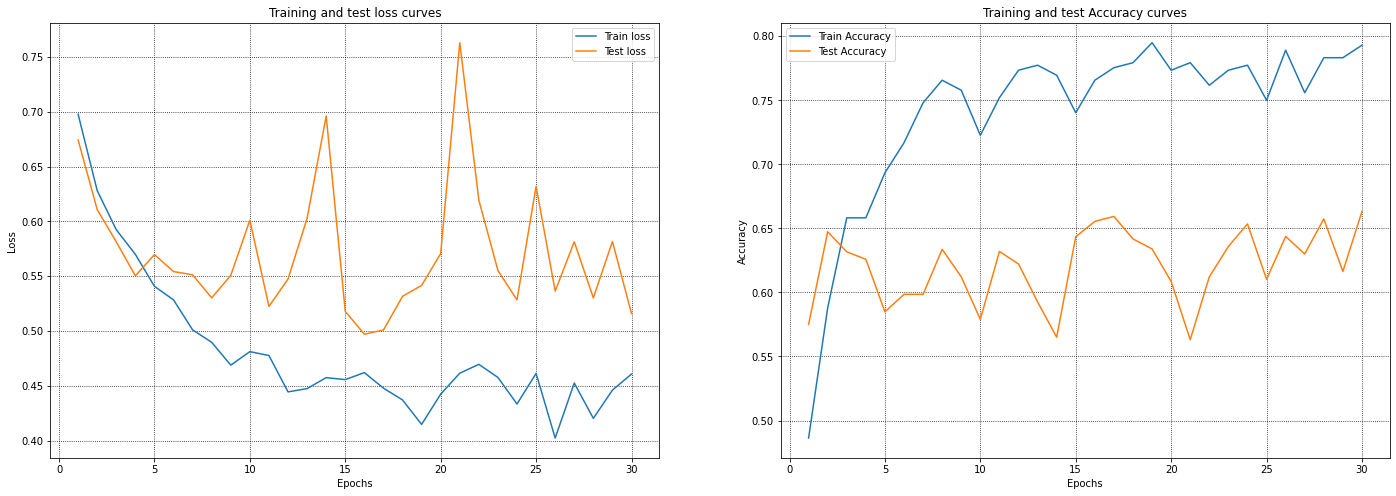

In [ ]:
plot_train_progress(resn_train_loss, resn_test_loss, resn_train_acc, resn_test_acc, 30)

And the evaluation of the model:

In [ ]:
model_X_results = eval_model(model=model_X, data_loader=testloader,
    loss_fn=loss_fn
)
model_X_results

{'model_name': 'ResNet',
 'model_loss': 0.5929014086723328,
 'model_acc': 0.7818080357142857}

The results are definitely better than the raw self-made model gave.

### Pretrained VGG-19 model

The next model to test is VGG-19. Again it is necessary to substitute the last layer in order to meet the task requirements.

In [ ]:
vgg19 = models.vgg19(pretrained=True)

#freeze all params
for params in vgg19.parameters():
  params.requires_grad_ = False

mod = list(vgg19.classifier.children())
mod.pop()
mod.append(torch.nn.Linear(4096, 1))
new_classifier = torch.nn.Sequential(*mod)
vgg19.classifier = new_classifier

vgg19 = vgg19.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
vgg19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Checking the structure of the NN and the number of its parameters:

In [ ]:
summary(vgg19, input_size=(3, 224, 224),device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Defining the loss function and the optimizer:

In [ ]:
#loss
loss_fn = nn.BCEWithLogitsLoss() #binary cross entropy with sigmoid, so no need to use sigmoid in the model
#optimizer
optimizer = torch.optim.Adam(vgg19.classifier.parameters())

And training:

In [ ]:
vgg19, vgg_train_losses, vgg_test_losses, vgg_train_acc, vgg_test_acc = model_train(trainloader, testloader, vgg19, loss_fn, device, 20)

  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 1, train loss : 0.9726470708847046, train accuracy: 0.650390625
Epoch : 1, val loss : 0.5623092651367188, test accuracy : 0.7028459821428571


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 2, train loss : 0.8648395538330078, train accuracy: 0.703125
Epoch : 2, val loss : 0.3870944082736969, test accuracy : 0.8270089285714286


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 3, train loss : 0.5861684083938599, train accuracy: 0.763671875
Epoch : 3, val loss : 0.3497922420501709, test accuracy : 0.8108258928571429


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 4, train loss : 0.6511755585670471, train accuracy: 0.771484375
Epoch : 4, val loss : 0.646901547908783, test accuracy : 0.708984375


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 5, train loss : 0.653056263923645, train accuracy: 0.748046875
Epoch : 5, val loss : 0.38056111335754395, test accuracy : 0.8392857142857143


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 6, train loss : 0.6193787455558777, train accuracy: 0.75390625
Epoch : 6, val loss : 0.5101745128631592, test accuracy : 0.8005022321428571


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 7, train loss : 0.7669983506202698, train accuracy: 0.73828125
Epoch : 7, val loss : 0.4343593418598175, test accuracy : 0.8256138392857143


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 8, train loss : 0.522961437702179, train accuracy: 0.765625
Epoch : 8, val loss : 0.3588109314441681, test accuracy : 0.8487723214285714


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 9, train loss : 0.6057385206222534, train accuracy: 0.787109375
Epoch : 9, val loss : 0.3599974811077118, test accuracy : 0.8264508928571429


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 10, train loss : 0.5370088815689087, train accuracy: 0.75390625
Epoch : 10, val loss : 0.37092387676239014, test accuracy : 0.8523995535714286


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 11, train loss : 0.6121869683265686, train accuracy: 0.74609375
Epoch : 11, val loss : 0.3760455548763275, test accuracy : 0.8526785714285714


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 12, train loss : 0.6464316844940186, train accuracy: 0.771484375
Epoch : 12, val loss : 0.36117881536483765, test accuracy : 0.8627232142857143


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 13, train loss : 0.5353137850761414, train accuracy: 0.794921875
Epoch : 13, val loss : 0.3777557611465454, test accuracy : 0.8568638392857143


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 14, train loss : 0.6410437822341919, train accuracy: 0.73046875
Epoch : 14, val loss : 0.38219112157821655, test accuracy : 0.8568638392857143


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 15, train loss : 0.5156445503234863, train accuracy: 0.802734375
Epoch : 15, val loss : 0.455582857131958, test accuracy : 0.765625


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 16, train loss : 0.48810499906539917, train accuracy: 0.78515625
Epoch : 16, val loss : 0.3655751347541809, test accuracy : 0.8526785714285714


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 17, train loss : 0.5923638343811035, train accuracy: 0.76953125
Epoch : 17, val loss : 0.41152244806289673, test accuracy : 0.8258928571428571


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 18, train loss : 0.5527456402778625, train accuracy: 0.7421875
Epoch : 18, val loss : 0.3526060879230499, test accuracy : 0.8465401785714286


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 19, train loss : 0.4721786677837372, train accuracy: 0.8125
Epoch : 19, val loss : 0.3318054974079132, test accuracy : 0.8780691964285714


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 20, train loss : 0.43164974451065063, train accuracy: 0.80859375
Epoch : 20, val loss : 0.4000641107559204, test accuracy : 0.8761160714285714


Checking the final accuracy and loss values (they are quite good):

In [ ]:
vgg19_results = eval_model(model=vgg19, data_loader=testloader,
    loss_fn=loss_fn
)
vgg19_results

{'model_name': 'VGG',
 'model_loss': 0.563054621219635,
 'model_acc': 0.8702566964285714}

And visualizing the training progress:

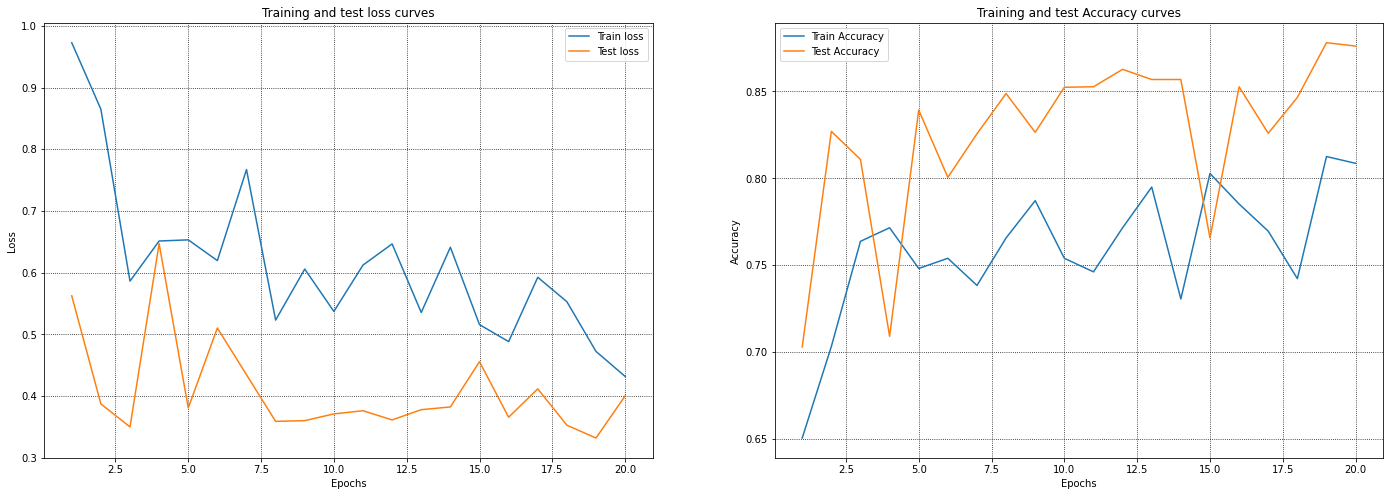

In [ ]:
plot_train_progress(vgg_train_losses, vgg_test_losses, vgg_train_acc, vgg_test_acc, 20)

Here on the plots, we can see that this model behaves similarly to the previous one - it initializes with not-zero prediction ability and learn to perform better during the training process. What is strange to me is the fact that it shows better characteristics for the test set than for the train set. Usually, it is vice versa.

And finally testing the model's predictions:

Prediction : Not a hotdog


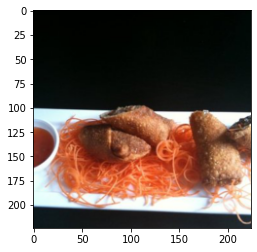

In [ ]:
inference(vgg19, test_data)

### Pretrained Convnext model

One more model to check is Convnext. I've decided to try Convnext Tiny - the smallest model from the family.

In [ ]:
convnext_model = models.convnext_tiny(pretrained=True)

#freeze all params
for params in convnext_model.parameters():
  params.requires_grad_ = False

convnext_model

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


  0%|          | 0.00/109M [00:00<?, ?B/s]

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

Substituting the last layer:

In [ ]:
mod = list(convnext_model.classifier.children())
mod.pop()
mod.append(torch.nn.Linear(768, 1))
new_classifier = torch.nn.Sequential(*mod)
convnext_model.classifier = new_classifier

convnext_model = convnext_model.to(device)

In [ ]:
convnext_model

Defining the loss and the optimizer:

In [ ]:
#loss
loss_fn = nn.BCEWithLogitsLoss() #binary cross entropy with sigmoid, so no need to use sigmoid in the model
#optimizer
optimizer = torch.optim.Adam(convnext_model.classifier.parameters(), lr=0.01)

Training:

In [ ]:
convnext_model, conv_train_losses, conv_test_losses, conv_train_acc, conv_test_acc = model_train(trainloader, testloader, convnext_model, loss_fn, device, 20)

  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 1, train loss : 0.41875213384628296, train accuracy: 0.8203125
Epoch : 1, val loss : 0.1601724922657013, test accuracy : 0.955078125


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 2, train loss : 0.2321176528930664, train accuracy: 0.900390625
Epoch : 2, val loss : 0.13609442114830017, test accuracy : 0.9547991071428571


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 3, train loss : 0.24880221486091614, train accuracy: 0.900390625
Epoch : 3, val loss : 0.18672995269298553, test accuracy : 0.9232700892857143


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 4, train loss : 0.25213414430618286, train accuracy: 0.88671875
Epoch : 4, val loss : 0.13564330339431763, test accuracy : 0.9508928571428571


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 5, train loss : 0.19518566131591797, train accuracy: 0.921875
Epoch : 5, val loss : 0.191914364695549, test accuracy : 0.9313616071428571


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 6, train loss : 0.23843148350715637, train accuracy: 0.904296875
Epoch : 6, val loss : 0.15450219810009003, test accuracy : 0.9489397321428571


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 7, train loss : 0.17701971530914307, train accuracy: 0.9296875
Epoch : 7, val loss : 0.15255089104175568, test accuracy : 0.9411272321428571


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 8, train loss : 0.19348518550395966, train accuracy: 0.921875
Epoch : 8, val loss : 0.16031457483768463, test accuracy : 0.9411272321428571


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 9, train loss : 0.18708893656730652, train accuracy: 0.921875
Epoch : 9, val loss : 0.14543239772319794, test accuracy : 0.9469866071428571


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 10, train loss : 0.22724129259586334, train accuracy: 0.916015625
Epoch : 10, val loss : 0.14912940561771393, test accuracy : 0.9489397321428571


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 11, train loss : 0.23111896216869354, train accuracy: 0.91015625
Epoch : 11, val loss : 0.1553802341222763, test accuracy : 0.9411272321428571


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 12, train loss : 0.1796395629644394, train accuracy: 0.93359375
Epoch : 12, val loss : 0.1458301991224289, test accuracy : 0.955078125


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 13, train loss : 0.23939549922943115, train accuracy: 0.8984375
Epoch : 13, val loss : 0.17285069823265076, test accuracy : 0.947265625


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 14, train loss : 0.18404985964298248, train accuracy: 0.921875
Epoch : 14, val loss : 0.15360774099826813, test accuracy : 0.9450334821428571


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 15, train loss : 0.17923229932785034, train accuracy: 0.939453125
Epoch : 15, val loss : 0.1604347676038742, test accuracy : 0.9430803571428571


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 16, train loss : 0.16149841248989105, train accuracy: 0.93359375
Epoch : 16, val loss : 0.15919159352779388, test accuracy : 0.9430803571428571


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 17, train loss : 0.2284175008535385, train accuracy: 0.92578125
Epoch : 17, val loss : 0.17800670862197876, test accuracy : 0.9489397321428571


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 18, train loss : 0.16720309853553772, train accuracy: 0.9296875
Epoch : 18, val loss : 0.17118552327156067, test accuracy : 0.9450334821428571


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 19, train loss : 0.18622355163097382, train accuracy: 0.912109375
Epoch : 19, val loss : 0.1810542792081833, test accuracy : 0.9450334821428571


  0%|          | 0/32 [00:00<?, ?it/s]


Epoch : 20, train loss : 0.1992998868227005, train accuracy: 0.92578125
Epoch : 20, val loss : 0.17153343558311462, test accuracy : 0.9489397321428571


And checking results:

In [ ]:
convnext_results = eval_model(model=convnext_model, data_loader=testloader,
    loss_fn=loss_fn
)
convnext_results

{'model_name': 'ConvNeXt',
 'model_loss': 0.527413547039032,
 'model_acc': 0.9430803571428571}

It seems that it is the best results so far.

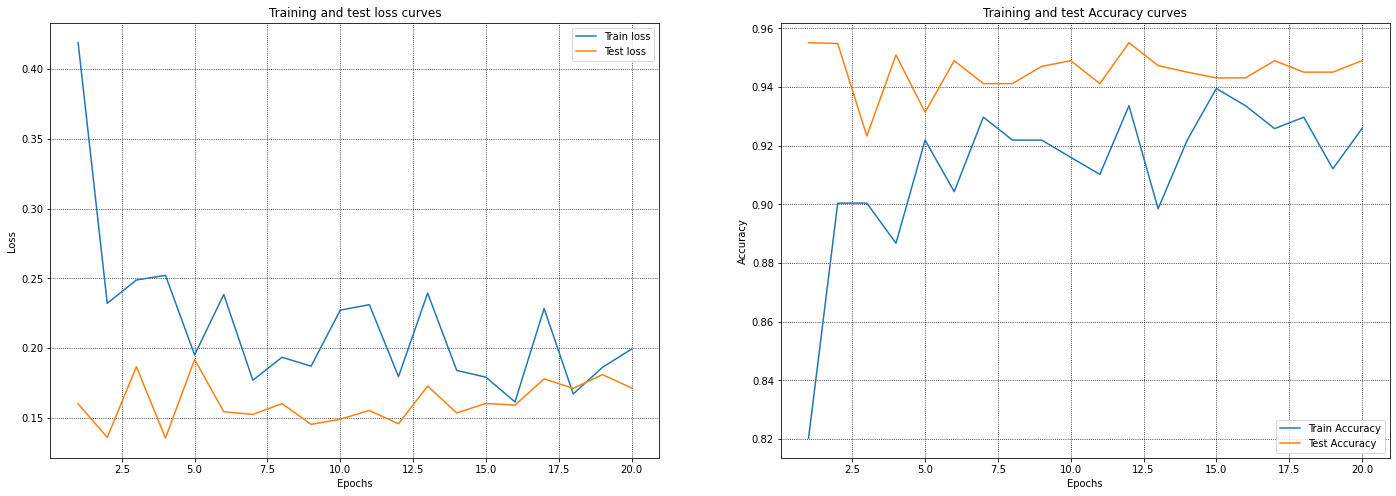

In [ ]:
plot_train_progress(conv_train_losses, conv_test_losses, conv_train_acc, conv_test_acc, 20)

Again the test loss is lower than the train one and accuracy is better instead. I have no explanation for this behavior.

Prediction : Hotdog


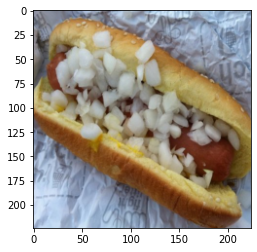

In [ ]:
inference(convnext_model, test_data)

But the quality of predictions of this model is quite good. For all my tries I have got the correct answers.

In [ ]:
cvx_model = models.convnext_tiny(pretrained=True)

#freeze all params
for params in cvx_model.parameters():
  params.requires_grad_ = False


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


  0%|          | 0.00/109M [00:00<?, ?B/s]

In [ ]:
mod = list(cvx_model.classifier.children())
mod.pop()
mod.append(torch.nn.Linear(768, 1))
new_classifier = torch.nn.Sequential(*mod)
cvx_model.classifier = new_classifier

cvx_model = cvx_model.to(device)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(cvx_model.classifier.parameters(), lr=0.01)

In [ ]:
cvx_results = eval_model(model=cvx_model, data_loader=testloader,
    loss_fn=loss_fn
)
cvx_results

{'model_name': 'ConvNeXt',
 'model_loss': 0.7646746039390564,
 'model_acc': 0.41238839285714285}

Conclusions on pretrained models:
I tried three models available in Torchvision library:
- Resnet18
- VGG19
- Convnext
<br>

All of them have a complicated structure and a huge number of parameters. Luckily these parameters are already learned so models are able to capture a lot of patterns in the images and generally show good results. They are almost ready to use right out of the box - with a quite a short training on the target dataset they all show very good accuracy of predictions. On the learning curves, we can see that the initial accuracy of 0.6-0.8 rapidly raised to 0.8-0.95 while models trained on designated data.

The best results show the Convnext model (accuracy=0.94), next in a row is VGG-19 (accuracy=0.87), and then goes Resnet18 (accuracy=0.78).


### Convolutional Network

As the last stage I would like to try to build by hand another CNN with a more complex architecture and find out if it will work. I am going to reproduce (with a little reduction of complexity) classical VGG-16 architecture. Here is the class describing the model:

In [ ]:
# Create a convolutional neural network
class ConvHotdogModel(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            # 224x224   112
            nn.Conv2d(in_channels=input_shape,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2),
            # 112x112    56
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2),
            #56x56    28
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2),
            #28x28    14
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2),

            )
            #14x14   7x7


        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=512*7*7,
                      out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096,
                      out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024,
                      out_features=output_shape),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
model_2 = ConvHotdogModel(input_shape=3,
    output_shape=1).to(device)
model_2

ConvHotdogModel(
  (block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), strid

In [ ]:
from torchsummary import summary
summary(model_2, input_size=(3, 112, 112),device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,792
              ReLU-2         [-1, 64, 112, 112]               0
            Conv2d-3        [-1, 128, 112, 112]          73,856
              ReLU-4        [-1, 128, 112, 112]               0
         MaxPool2d-5          [-1, 128, 56, 56]               0
            Conv2d-6          [-1, 128, 56, 56]         147,584
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 256, 56, 56]         295,168
              ReLU-9          [-1, 256, 56, 56]               0
        MaxPool2d-10          [-1, 256, 28, 28]               0
           Conv2d-11          [-1, 256, 28, 28]         590,080
             ReLU-12          [-1, 256, 28, 28]               0
           Conv2d-13          [-1, 512, 28, 28]       1,180,160
             ReLU-14          [-1, 512,

Defining the loss function and the optimizer (the same as in previous cases):

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
#loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

In [ ]:
torch.cuda.empty_cache()

Training process:

In [ ]:
model_2, m2_train_loss, m2_test_losses, m2_train_acc, m2_test_acc = model_train(trainloader, testloader, model_2, loss_fn, device, 50)

  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 1, train loss : 0.6931473016738892, train accuracy: 0.4969618055555556
Epoch : 1, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 2, train loss : 0.6931473016738892, train accuracy: 0.5
Epoch : 2, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 3, train loss : 0.6931473016738892, train accuracy: 0.4984809027777778
Epoch : 3, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 4, train loss : 0.6931473016738892, train accuracy: 0.4954427083333333
Epoch : 4, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 5, train loss : 0.6931473016738892, train accuracy: 0.4954427083333333
Epoch : 5, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 6, train loss : 0.6931473016738892, train accuracy: 0.4984809027777778
Epoch : 6, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 7, train loss : 0.6931473016738892, train accuracy: 0.4969618055555556
Epoch : 7, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 8, train loss : 0.6931473016738892, train accuracy: 0.4954427083333333
Epoch : 8, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 9, train loss : 0.6931473016738892, train accuracy: 0.5075954861111112
Epoch : 9, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 10, train loss : 0.6931473016738892, train accuracy: 0.4984809027777778
Epoch : 10, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 11, train loss : 0.6931473016738892, train accuracy: 0.5015190972222222
Epoch : 11, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 12, train loss : 0.6931473016738892, train accuracy: 0.5015190972222222
Epoch : 12, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 13, train loss : 0.6931473016738892, train accuracy: 0.5045572916666666
Epoch : 13, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 14, train loss : 0.6931473016738892, train accuracy: 0.5045572916666666
Epoch : 14, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 15, train loss : 0.6931473016738892, train accuracy: 0.5015190972222222
Epoch : 15, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 16, train loss : 0.6931473016738892, train accuracy: 0.5030381944444444
Epoch : 16, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 17, train loss : 0.6931473016738892, train accuracy: 0.5030381944444444
Epoch : 17, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 18, train loss : 0.6931473016738892, train accuracy: 0.4984809027777778
Epoch : 18, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 19, train loss : 0.6931473016738892, train accuracy: 0.4984809027777778
Epoch : 19, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 20, train loss : 0.6931473016738892, train accuracy: 0.4969618055555556
Epoch : 20, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 21, train loss : 0.6931473016738892, train accuracy: 0.4939236111111111
Epoch : 21, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 22, train loss : 0.6931473016738892, train accuracy: 0.4954427083333333
Epoch : 22, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 23, train loss : 0.6931473016738892, train accuracy: 0.5030381944444444
Epoch : 23, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 24, train loss : 0.6931473016738892, train accuracy: 0.5030381944444444
Epoch : 24, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 25, train loss : 0.6931473016738892, train accuracy: 0.4969618055555556
Epoch : 25, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 26, train loss : 0.6931473016738892, train accuracy: 0.5045572916666666
Epoch : 26, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 27, train loss : 0.6931473016738892, train accuracy: 0.4984809027777778
Epoch : 27, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 28, train loss : 0.6931473016738892, train accuracy: 0.5015190972222222
Epoch : 28, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 29, train loss : 0.6931473016738892, train accuracy: 0.5045572916666666
Epoch : 29, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 30, train loss : 0.6931473016738892, train accuracy: 0.5015190972222222
Epoch : 30, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 31, train loss : 0.6931473016738892, train accuracy: 0.4969618055555556
Epoch : 31, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 32, train loss : 0.6931473016738892, train accuracy: 0.4939236111111111
Epoch : 32, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 33, train loss : 0.6931473016738892, train accuracy: 0.4984809027777778
Epoch : 33, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 34, train loss : 0.6931473016738892, train accuracy: 0.4984809027777778
Epoch : 34, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 35, train loss : 0.6931473016738892, train accuracy: 0.4984809027777778
Epoch : 35, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 36, train loss : 0.6931473016738892, train accuracy: 0.5030381944444444
Epoch : 36, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 37, train loss : 0.6931473016738892, train accuracy: 0.5060763888888888
Epoch : 37, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 38, train loss : 0.6931473016738892, train accuracy: 0.5015190972222222
Epoch : 38, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 39, train loss : 0.6931473016738892, train accuracy: 0.5045572916666666
Epoch : 39, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 40, train loss : 0.6931473016738892, train accuracy: 0.5030381944444444
Epoch : 40, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 41, train loss : 0.6931473016738892, train accuracy: 0.5
Epoch : 41, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 42, train loss : 0.6931473016738892, train accuracy: 0.4969618055555556
Epoch : 42, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 43, train loss : 0.6931473016738892, train accuracy: 0.5015190972222222
Epoch : 43, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 44, train loss : 0.6931473016738892, train accuracy: 0.4969618055555556
Epoch : 44, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 45, train loss : 0.6931473016738892, train accuracy: 0.4984809027777778
Epoch : 45, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 46, train loss : 0.6931473016738892, train accuracy: 0.4984809027777778
Epoch : 46, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 47, train loss : 0.6931473016738892, train accuracy: 0.5045572916666666
Epoch : 47, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 48, train loss : 0.6931473016738892, train accuracy: 0.5
Epoch : 48, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 49, train loss : 0.6931473016738892, train accuracy: 0.4969618055555556
Epoch : 49, val loss : 0.6931473016738892, test accuracy : 0.48828125


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch : 50, train loss : 0.6931473016738892, train accuracy: 0.5
Epoch : 50, val loss : 0.6931473016738892, test accuracy : 0.48828125


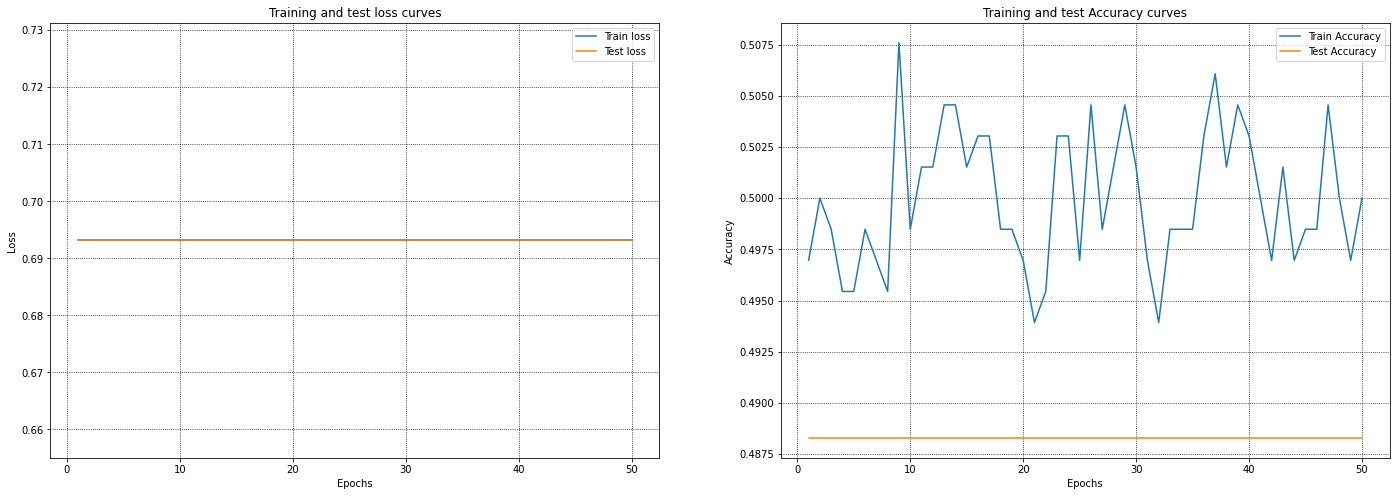

In [ ]:
plot_train_progress(m2_train_loss, m2_test_losses, m2_train_acc, m2_test_acc, 50)

In [ ]:
# Calculate model 0 results on test dataset
model_2_results = eval_model(model=model_2, data_loader=testloader,
    loss_fn=loss_fn
)
model_2_results

{'model_name': 'ConvHotdogModel',
 'model_loss': 0.6931473016738892,
 'model_acc': 0.48828125}

Unfortunately, I couldn't manage to build a custom CNN and more important make it work properly. The NN that I made seems consistent and in my opinion, it should work but in fact, it doesn't learn from the data it trained on. More probably I made make some errors in the train loop. I completely messed up with logits, probabilities, and labels - what should be where, and I got out of time to properly debug this training loop. I hope to get back to this code and make it work.

## Conclusions:

In this work, I get familiar with the neural network approach to different machine learning tasks. The first and the most simple was the regression task. In order to solve it I built two models. The first was the simple NN with one linear layer - it didn't capture non-linear dependencies in the data and therefore made bad predictions. The second was a more complex multilayer NN with activations between layers. The latest model has shown good performance comparable with advanced regression models I trained in recent homework on linear regression.

The next task was to build NN for the classification task on the hypothyroid dataset. This task was also successively solved using the NN containing four layers with ReLU activations. I have trained this model on the given dataset and reached up to 97% of test accuracy. R2 score at the same time was 0.88. These results could be compared with the best classic models' results we got in classification homework. In my case, it is comparable with the random forest model's results.

The third task in this homework is to build different models aimed to recognize images particularly to perform the binary classification task of recognizing images with hotdogs among others not containing hotdogs. Here I have got familiar with different techniques and methods of image preparation and augmentation, learned how to build a convolutional neural network, learned the concept of transfer learning - using pre-trained models on new data, trained several pre-trained models from torchvision library, and compared their performance. Sadly I couldn't manage to train my own custom NN to effectively recognize images but I put this on the to-do list and will get back to this in near future.